Import important parameter

In [1]:
inputsize =11**2
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)
sqrtinputsize = int(np.sqrt(inputsize))     
sqrtoutputsize = int(sqrtinputsize/2)
outputsize = int(sqrtoutputsize**2)
h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R = Restriction(inputsize)
P = 4*np.transpose(R)

Linear = 0.23710749835313513


GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 17.89269088109051
Interation = 1
Residual = 1.6493615189462238
Interation = 2
Residual = 0.4431325062986437
Interation = 3
Residual = 0.15715991718713845
Interation = 4
Residual = 0.06126167752773567
Interation = 5
Residual = 0.025214041024889774
Interation = 6
Residual = 0.010791268831823452
Interation = 7
Residual = 0.004754234664854396
Interation = 8
Residual = 0.002139349768604023
Interation = 9
Residual = 0.0009775033043185667
Interation = 10
Residual = 0.0004515806727520585
Interation = 11
Residual = 0.0002102935081211918
Interation = 12
Residual = 9.850964764440812e-05
Interation = 13
Residual = 4.635088615125719e-05
Interation = 14
Residual = 2.188341342657303e-05
Interation = 15
Residual = 1.0359254763224653e-05
Interation = 16
Residual = 4.914328305586576e-06
Interation = 17
Residual = 2.3353294260506485e-06
Interation = 18
Residual = 1.1113453908986646e-06
Interation = 19
Residual = 5.294998080033211e-07
Interation = 20
Residual = 2.525337390318022e-07
Interation 

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
3.5199829668256437
L2 norm: 
0.27973173830264714
H1 norm: 
2.585715246127616
Energy norm: 
0.35325898087708224
L2 norm: 
0.5594634766052943
H1 norm: 
0.36609567502773993


Solution

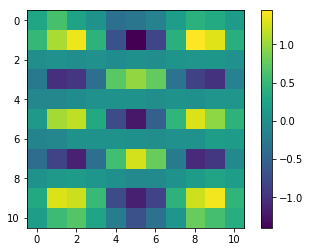

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

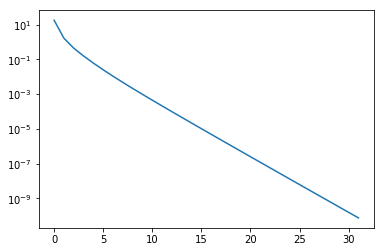

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.4868857583559788


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-4,accept_radius =
                                                           GMM_Radius*10,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.43432279333173757
L = 0.03
rho = 0.43438594301598427
L = 0.04
rho = 0.43451650786799906
L = 0.05
rho = 0.4347089353232339
L = 0.060000000000000005
rho = 0.43495768338594026
L = 0.07
rho = 0.4352573292667929
L = 0.08
rho = 0.43560265763622796
L = 0.09
rho = 0.4359887268624454
L = 0.09999999999999999
rho = 0.4364109139446881
L = 0.10999999999999999
rho = 0.43686494043415736
L = 0.11999999999999998
rho = 0.43734688249070913
L = 0.12999999999999998
rho = 0.4378531684922035
L = 0.13999999999999999
rho = 0.4383805674711848
L = 0.15
rho = 0.4389261712672105
L = 0.16
rho = 0.4394873727860781
L = 0.17
rho = 0.4400618422427533
L = 0.18000000000000002
rho = 0.440647502789853
L = 0.19000000000000003
rho = 0.441242506526633
L = 0.20000000000000004
rho = 0.4418452115536486
L = 0.21000000000000005
rho = 0.44245416048284436
L = 0.22000000000000006
rho = 0.4430680606228567
L = 0.23000000000000007
rho = 0.44368576592349673
L = 0.24000000000000007
rho = 0.4443062606

the 35 steps
rho = 0.48068521241991685
the 36 steps
rho = 0.48063918373288766
the 37 steps
rho = 0.4805931641582877
the 38 steps
rho = 0.4805471536794298
the 39 steps
rho = 0.4805011522796953
the 40 steps
rho = 0.4804551599425334
the 41 steps
rho = 0.48040917665146105
the 42 steps
rho = 0.48036320239006214
the 43 steps
rho = 0.4803172371419879
the 44 steps
rho = 0.480271280890956
the 45 steps
rho = 0.48022533362075054
the 46 steps
rho = 0.4801793953152217
the 47 steps
rho = 0.48013346595828554
the 48 steps
rho = 0.4800875455339235
the 49 steps
rho = 0.4800416340261821
the 50 steps
rho = 0.47999573141917273
the 51 steps
rho = 0.47994983769707145
the 52 steps
rho = 0.4799039528441187
the 53 steps
rho = 0.47985807684461873
the 54 steps
rho = 0.4798122096829394
the 55 steps
rho = 0.47976635134351214
the 56 steps
rho = 0.47972050181083153
the 57 steps
rho = 0.4796746610694549
the 58 steps
rho = 0.479628829104002
the 59 steps
rho = 0.4795830058991549
the 60 steps
rho = 0.47953719143965784
th

the 192 steps
rho = 0.47356119546173114
the 193 steps
rho = 0.47351642960548174
the 194 steps
rho = 0.4734716709105998
the 195 steps
rho = 0.4734269193680598
the 196 steps
rho = 0.47338217496887003
the 197 steps
rho = 0.47333743770407155
the 198 steps
rho = 0.4732927075647386
the 199 steps
rho = 0.47324798454197864
the 200 steps
rho = 0.47320326862693135
the 201 steps
rho = 0.47315855981076943
the 202 steps
rho = 0.4731138580846978
the 203 steps
rho = 0.47306916343995375
the 204 steps
rho = 0.4730244758678069
the 205 steps
rho = 0.4729797953595585
the 206 steps
rho = 0.472935121906542
the 207 steps
rho = 0.47289045550012254
the 208 steps
rho = 0.47284579613169675
the 209 steps
rho = 0.47280114379269267
the 210 steps
rho = 0.4727564984745699
the 211 steps
rho = 0.47271186016881866
the 212 steps
rho = 0.4726672288669609
the 213 steps
rho = 0.47262260456054894
the 214 steps
rho = 0.472577987241166
the 215 steps
rho = 0.4725333769004259
the 216 steps
rho = 0.4724887735299729
the 217 steps


the 350 steps
rho = 0.46657192177706386
the 351 steps
rho = 0.4665281937058272
the 352 steps
rho = 0.4664844717018693
the 353 steps
rho = 0.46644075575995114
the 354 steps
rho = 0.46639704587485004
the 355 steps
rho = 0.46635334204136014
the 356 steps
rho = 0.46630964425429156
the 357 steps
rho = 0.466265952508471
the 358 steps
rho = 0.4662222667987416
the 359 steps
rho = 0.4661785871199623
the 360 steps
rho = 0.46613491346700864
the 361 steps
rho = 0.4660912458347719
the 362 steps
rho = 0.4660475842181594
the 363 steps
rho = 0.4660039286120945
the 364 steps
rho = 0.4659602790115164
the 365 steps
rho = 0.46591663541138006
the 366 steps
rho = 0.46587299780665614
the 367 steps
rho = 0.4658293661923312
the 368 steps
rho = 0.46578574056340694
the 369 steps
rho = 0.46574212091490097
the 370 steps
rho = 0.46569850724184625
the 371 steps
rho = 0.46565489953929107
the 372 steps
rho = 0.46561129780229926
the 373 steps
rho = 0.4655677020259496
the 374 steps
rho = 0.4655241122053363
the 375 steps

the 489 steps
rho = 0.4605498373318047
the 490 steps
rho = 0.46050690868356253
the 491 steps
rho = 0.46046398550658585
the 492 steps
rho = 0.4604210677973846
the 493 steps
rho = 0.46037815555247796
the 494 steps
rho = 0.4603352487683943
the 495 steps
rho = 0.46029234744167175
the 496 steps
rho = 0.46024945156885727
the 497 steps
rho = 0.460206561146507
the 498 steps
rho = 0.4601636761711865
the 499 steps
rho = 0.46012079663947036
the 500 steps
rho = 0.46007792254794233
the 501 steps
rho = 0.460035053893195
the 502 steps
rho = 0.4599921906718302
the 503 steps
rho = 0.4599493328804588
the 504 steps
rho = 0.45990648051570043
the 505 steps
rho = 0.45986363357418386
the 506 steps
rho = 0.4598207920525465
the 507 steps
rho = 0.45977795594743487
the 508 steps
rho = 0.4597351252555041
the 509 steps
rho = 0.45969229997341843
the 510 steps
rho = 0.45964948009785045
the 511 steps
rho = 0.4596066656254818
the 512 steps
rho = 0.45956385655300247
the 513 steps
rho = 0.4595210528771116
the 514 steps


the 652 steps
rho = 0.45362246776716175
the 653 steps
rho = 0.453580390587597
the 654 steps
rho = 0.45353831841231096
the 655 steps
rho = 0.45349625123895887
the 656 steps
rho = 0.453454189065201
the 657 steps
rho = 0.4534121318887032
the 658 steps
rho = 0.45337007970713616
the 659 steps
rho = 0.45332803251817566
the 660 steps
rho = 0.4532859903195029
the 661 steps
rho = 0.4532439531088039
the 662 steps
rho = 0.45320192088377
the 663 steps
rho = 0.45315989364209747
the 664 steps
rho = 0.45311787138148774
the 665 steps
rho = 0.4530758540996472
the 666 steps
rho = 0.4530338417942873
the 667 steps
rho = 0.4529918344631246
the 668 steps
rho = 0.4529498321038804
the 669 steps
rho = 0.4529078347142815
the 670 steps
rho = 0.45286584229205873
the 671 steps
rho = 0.45282385483494897
the 672 steps
rho = 0.45278187234069334
the 673 steps
rho = 0.4527398948070379
the 674 steps
rho = 0.4526979222317339
the 675 steps
rho = 0.45265595461253716
the 676 steps
rho = 0.45261399194720886
the 677 steps
rho

the 812 steps
rho = 0.4469523267177163
the 813 steps
rho = 0.4469110234843547
the 814 steps
rho = 0.4468697249364921
the 815 steps
rho = 0.44682843107244047
the 816 steps
rho = 0.4467871418905149
the 817 steps
rho = 0.4467458573890339
the 818 steps
rho = 0.44670457756631915
the 819 steps
rho = 0.44666330242069546
the 820 steps
rho = 0.4466220319504908
the 821 steps
rho = 0.44658076615403647
the 822 steps
rho = 0.4465395050296668
the 823 steps
rho = 0.44649824857571935
the 824 steps
rho = 0.4464569967905349
the 825 steps
rho = 0.44641574967245734
the 826 steps
rho = 0.4463745072198335
the 827 steps
rho = 0.4463332694310138
the 828 steps
rho = 0.4462920363043514
the 829 steps
rho = 0.44625080783820253
the 830 steps
rho = 0.446209584030927
the 831 steps
rho = 0.44616836488088724
the 832 steps
rho = 0.44612715038644896
the 833 steps
rho = 0.44608594054598094
the 834 steps
rho = 0.44604473535785516
the 835 steps
rho = 0.4460035348204465
the 836 steps
rho = 0.445962338932133
the 837 steps
rh

the 951 steps
rho = 0.44125542149066305
the 952 steps
rho = 0.4412147546513595
the 953 steps
rho = 0.4411740922906109
the 954 steps
rho = 0.44113343440710956
the 955 steps
rho = 0.4410927809995502
the 956 steps
rho = 0.4410521320666297
the 957 steps
rho = 0.44101148760704745
the 958 steps
rho = 0.440970847619505
the 959 steps
rho = 0.4409302121027065
the 960 steps
rho = 0.4408895810553579
the 961 steps
rho = 0.44084895447616784
the 962 steps
rho = 0.44080833236384714
the 963 steps
rho = 0.44076771471710896
the 964 steps
rho = 0.4407271015346686
the 965 steps
rho = 0.44068649281524397
the 966 steps
rho = 0.44064588855755477
the 967 steps
rho = 0.4406052887603233
the 968 steps
rho = 0.44056469342227406
the 969 steps
rho = 0.4405241025421338
the 970 steps
rho = 0.4404835161186315
the 971 steps
rho = 0.44044293415049857
the 972 steps
rho = 0.44040235663646826
the 973 steps
rho = 0.44036178357527667
the 974 steps
rho = 0.4403212149656615
the 975 steps
rho = 0.44028065080636314
the 976 steps

the 1102 steps
rho = 0.43516475866899135
the 1103 steps
rho = 0.43512475450382576
the 1104 steps
rho = 0.4350847546438305
the 1105 steps
rho = 0.4350447590880058
the 1106 steps
rho = 0.4350047678353535
the 1107 steps
rho = 0.43496478088487794
the 1108 steps
rho = 0.4349247982355845
the 1109 steps
rho = 0.434884819886481
the 1110 steps
rho = 0.43484484583657657
the 1111 steps
rho = 0.43480487608488255
the 1112 steps
rho = 0.43476491063041184
the 1113 steps
rho = 0.4347249494721793
the 1114 steps
rho = 0.43468499260920124
the 1115 steps
rho = 0.43464504004049626
the 1116 steps
rho = 0.4346050917650843
the 1117 steps
rho = 0.4345651477819872
the 1118 steps
rho = 0.43452520809022904
the 1119 steps
rho = 0.4344852726888351
the 1120 steps
rho = 0.43444534157683257
the 1121 steps
rho = 0.43440541475325056
the 1122 steps
rho = 0.4343654922171202
the 1123 steps
rho = 0.43432557396747384
the 1124 steps
rho = 0.4342856600033458
the 1125 steps
rho = 0.43424575032377244
the 1126 steps
rho = 0.43420

the 1238 steps
rho = 0.42976332779772775
the 1239 steps
rho = 0.4297239006772128
the 1240 steps
rho = 0.429684477741849
the 1241 steps
rho = 0.42964505899086913
the 1242 steps
rho = 0.4296056444235072
the 1243 steps
rho = 0.4295662340389991
the 1244 steps
rho = 0.42952682783658247
the 1245 steps
rho = 0.42948742581549637
the 1246 steps
rho = 0.42944802797498177
the 1247 steps
rho = 0.42940863431428106
the 1248 steps
rho = 0.42936924483263833
the 1249 steps
rho = 0.4293298595292993
the 1250 steps
rho = 0.4292904784035115
the 1251 steps
rho = 0.4292511014545237
the 1252 steps
rho = 0.42921172868158686
the 1253 steps
rho = 0.42917236008395315
the 1254 steps
rho = 0.42913299566087665
the 1255 steps
rho = 0.4290936354116129
the 1256 steps
rho = 0.4290542793354192
the 1257 steps
rho = 0.42901492743155445
the 1258 steps
rho = 0.42897557969927924
the 1259 steps
rho = 0.42893623613785553
the 1260 steps
rho = 0.4288968967465476
the 1261 steps
rho = 0.42885756152462046
the 1262 steps
rho = 0.4288

the 1378 steps
rho = 0.42428393425119454
the 1379 steps
rho = 0.42424508632472163
the 1380 steps
rho = 0.4242062424921229
the 1381 steps
rho = 0.4241674027528666
the 1382 steps
rho = 0.42412856710642255
the 1383 steps
rho = 0.4240897355522628
the 1384 steps
rho = 0.42405090808986085
the 1385 steps
rho = 0.4240120847186921
the 1386 steps
rho = 0.4239732654382338
the 1387 steps
rho = 0.42393445024796483
the 1388 steps
rho = 0.42389563914736605
the 1389 steps
rho = 0.4238568321359199
the 1390 steps
rho = 0.42381802921311096
the 1391 steps
rho = 0.4237792303784253
the 1392 steps
rho = 0.423740435631351
the 1393 steps
rho = 0.4237016449713777
the 1394 steps
rho = 0.42366285839799717
the 1395 steps
rho = 0.42362407591070284
the 1396 steps
rho = 0.42358529750898993
the 1397 steps
rho = 0.4235465231923556
the 1398 steps
rho = 0.4235077529602987
the 1399 steps
rho = 0.42346898681232
the 1400 steps
rho = 0.4234302247479219
the 1401 steps
rho = 0.4233914667666092
the 1402 steps
rho = 0.4233527128

the 1526 steps
rho = 0.4185787287278021
the 1527 steps
rho = 0.4185404819169971
the 1528 steps
rho = 0.418502239142623
the 1529 steps
rho = 0.418464000404455
the 1530 steps
rho = 0.41842576570227075
the 1531 steps
rho = 0.41838753503585
the 1532 steps
rho = 0.4183493084049758
the 1533 steps
rho = 0.41831108580943305
the 1534 steps
rho = 0.4182728672490094
the 1535 steps
rho = 0.41823465272349525
the 1536 steps
rho = 0.41819644223268326
the 1537 steps
rho = 0.41815823577636885
the 1538 steps
rho = 0.41812003335435
the 1539 steps
rho = 0.4180818349664272
the 1540 steps
rho = 0.41804364061240346
the 1541 steps
rho = 0.4180054502920847
the 1542 steps
rho = 0.41796726400527917
the 1543 steps
rho = 0.41792908175179777
the 1544 steps
rho = 0.4178909035314542
the 1545 steps
rho = 0.41785272934406453
the 1546 steps
rho = 0.41781455918944765
the 1547 steps
rho = 0.4177763930674253
the 1548 steps
rho = 0.4177382309778215
the 1549 steps
rho = 0.417700072920463
the 1550 steps
rho = 0.41766191889517

the 1672 steps
rho = 0.41303735636857003
the 1673 steps
rho = 0.41299969795797414
the 1674 steps
rho = 0.4129620435831055
the 1675 steps
rho = 0.4129243932442348
the 1676 steps
rho = 0.41288674694163674
the 1677 steps
rho = 0.41284910467559083
the 1678 steps
rho = 0.41281146644638156
the 1679 steps
rho = 0.41277383225429815
the 1680 steps
rho = 0.41273620209963424
the 1681 steps
rho = 0.41269857598268883
the 1682 steps
rho = 0.4126609539037653
the 1683 steps
rho = 0.412623335863172
the 1684 steps
rho = 0.41258572186122233
the 1685 steps
rho = 0.4125481118982344
the 1686 steps
rho = 0.4125105059745314
the 1687 steps
rho = 0.4124729040904414
the 1688 steps
rho = 0.4124353062462976
the 1689 steps
rho = 0.4123977124424379
the 1690 steps
rho = 0.41236012267920563
the 1691 steps
rho = 0.412322536956949
the 1692 steps
rho = 0.4122849552760212
the 1693 steps
rho = 0.41224737763678093
the 1694 steps
rho = 0.4122098040395916
the 1695 steps
rho = 0.41217223448482215
the 1696 steps
rho = 0.4121346

the 1810 steps
rho = 0.40787884063741014
the 1811 steps
rho = 0.40784174417350444
the 1812 steps
rho = 0.4078046518413073
the 1813 steps
rho = 0.4077675636420914
the 1814 steps
rho = 0.4077304795771406
the 1815 steps
rho = 0.4076933996477502
the 1816 steps
rho = 0.407656323855227
the 1817 steps
rho = 0.4076192522008888
the 1818 steps
rho = 0.40758218468606516
the 1819 steps
rho = 0.4075451213120974
the 1820 steps
rho = 0.4075080620803382
the 1821 steps
rho = 0.4074710069921524
the 1822 steps
rho = 0.40743395604891625
the 1823 steps
rho = 0.4073969092520185
the 1824 steps
rho = 0.40735986660285944
the 1825 steps
rho = 0.4073228281028519
the 1826 steps
rho = 0.40728579375342083
the 1827 steps
rho = 0.4072487635560033
the 1828 steps
rho = 0.4072117375120491
the 1829 steps
rho = 0.4071747156230205
the 1830 steps
rho = 0.40713769789039217
the 1831 steps
rho = 0.4071006843156517
the 1832 steps
rho = 0.4070636749002996
the 1833 steps
rho = 0.4070266696458488
the 1834 steps
rho = 0.40698966855

the 1955 steps
rho = 0.40254387325169144
the 1956 steps
rho = 0.40250739676953085
the 1957 steps
rho = 0.4024709247832118
the 1958 steps
rho = 0.402434457297174
the 1959 steps
rho = 0.4023979943158975
the 1960 steps
rho = 0.40236153584390316
the 1961 steps
rho = 0.40232508188575317
the 1962 steps
rho = 0.4022886324460519
the 1963 steps
rho = 0.4022521875294454
the 1964 steps
rho = 0.40221574714062297
the 1965 steps
rho = 0.4021793112843168
the 1966 steps
rho = 0.4021428799653024
the 1967 steps
rho = 0.4021064531884
the 1968 steps
rho = 0.4020700309584741
the 1969 steps
rho = 0.40203361328043424
the 1970 steps
rho = 0.4019972001592356
the 1971 steps
rho = 0.40196079159987935
the 1972 steps
rho = 0.4019243876074134
the 1973 steps
rho = 0.4018879881869325
the 1974 steps
rho = 0.4018515933435792
the 1975 steps
rho = 0.40181520308254426
the 1976 steps
rho = 0.4017788174090669
the 1977 steps
rho = 0.40174243632843565
the 1978 steps
rho = 0.4017060598459887
the 1979 steps
rho = 0.401669687967

the 2101 steps
rho = 0.3972692113071334
the 2102 steps
rho = 0.397233471322026
the 2103 steps
rho = 0.3971977373138053
the 2104 steps
rho = 0.3971620093035325
the 2105 steps
rho = 0.39712628731254246
the 2106 steps
rho = 0.3970905713624485
the 2107 steps
rho = 0.3970548614751466
the 2108 steps
rho = 0.39701915767281987
the 2109 steps
rho = 0.3969834599779436
the 2110 steps
rho = 0.3969477684132899
the 2111 steps
rho = 0.39691208300193215
the 2112 steps
rho = 0.39687640376725053
the 2113 steps
rho = 0.3968407307329368
the 2114 steps
rho = 0.3968050639229992
the 2115 steps
rho = 0.3967694033617681
the 2116 steps
rho = 0.3967337490739012
the 2117 steps
rho = 0.39669810108438863
the 2118 steps
rho = 0.3966624594185591
the 2119 steps
rho = 0.396626824102085
the 2120 steps
rho = 0.3965911951609883
the 2121 steps
rho = 0.3965555726216467
the 2122 steps
rho = 0.3965199565107993
the 2123 steps
rho = 0.3964843468555529
the 2124 steps
rho = 0.3964487436833878
the 2125 steps
rho = 0.39641314702216

the 2239 steps
rho = 0.39240942822984476
the 2240 steps
rho = 0.3923749495970276
the 2241 steps
rho = 0.39234048671584804
the 2242 steps
rho = 0.3923060397726306
the 2243 steps
rho = 0.3922716089571495
the 2244 steps
rho = 0.39223719446269595
the 2245 steps
rho = 0.39220279648614764
the 2246 steps
rho = 0.3921684152280386
the 2247 steps
rho = 0.3921340508926309
the 2248 steps
rho = 0.3920997036879874
the 2249 steps
rho = 0.39206537382604595
the 2250 steps
rho = 0.3920310615226949
the 2251 steps
rho = 0.3919967669978498
the 2252 steps
rho = 0.39196249047553205
the 2253 steps
rho = 0.3919282321839485
the 2254 steps
rho = 0.3918939923555717
the 2255 steps
rho = 0.3918597712272236
the 2256 steps
rho = 0.39182556904015836
the 2257 steps
rho = 0.39179138604014857
the 2258 steps
rho = 0.3917572224775716
the 2259 steps
rho = 0.391723078607498
the 2260 steps
rho = 0.3916889546897814
the 2261 steps
rho = 0.3916548509891496
the 2262 steps
rho = 0.3916207677752978
the 2263 steps
rho = 0.3915867053

the 2382 steps
rho = 0.38783080246410856
the 2383 steps
rho = 0.38780379388765385
the 2384 steps
rho = 0.3877769102700215
the 2385 steps
rho = 0.3877501531097265
the 2386 steps
rho = 0.38772352390439685
the 2387 steps
rho = 0.38769702414993434
the 2388 steps
rho = 0.38767065533965295
the 2389 steps
rho = 0.38764441896339497
the 2390 steps
rho = 0.38761831650662415
the 2391 steps
rho = 0.3875923494494977
the 2392 steps
rho = 0.38756651926591806
the 2393 steps
rho = 0.38754082742256246
the 2394 steps
rho = 0.3875152753778955
the 2395 steps
rho = 0.3874898645811608
the 2396 steps
rho = 0.38746459647135634
the 2397 steps
rho = 0.38743947247619237
the 2398 steps
rho = 0.38741449401103306
the 2399 steps
rho = 0.3873896624778244
the 2400 steps
rho = 0.38736497926400765
the 2401 steps
rho = 0.3873404457414212
the 2402 steps
rho = 0.3873160632651908
the 2403 steps
rho = 0.3872918331726107
the 2404 steps
rho = 0.387267756782016
the 2405 steps
rho = 0.3872438353916493
the 2406 steps
rho = 0.38722

the 2520 steps
rho = 0.3855819834429547
the 2521 steps
rho = 0.3855750788760846
the 2522 steps
rho = 0.3855682481990415
the 2523 steps
rho = 0.38556149002138923
the 2524 steps
rho = 0.3855548029710329
the 2525 steps
rho = 0.38554818569442356
the 2526 steps
rho = 0.3855416368567387
the 2527 steps
rho = 0.3855351551420395
the 2528 steps
rho = 0.3855287392534052
the 2529 steps
rho = 0.38552238791304566
the 2530 steps
rho = 0.38551609986239277
the 2531 steps
rho = 0.38550987386217117
the 2532 steps
rho = 0.38550370869244943
the 2533 steps
rho = 0.3854976031526723
the 2534 steps
rho = 0.3854915560616741
the 2535 steps
rho = 0.38548556625767555
the 2536 steps
rho = 0.3854796325982625
the 2537 steps
rho = 0.38547375396035005
the 2538 steps
rho = 0.38546792924012996
the 2539 steps
rho = 0.38546215735300393
the 2540 steps
rho = 0.3854564372335034
the 2541 steps
rho = 0.38545076783519533
the 2542 steps
rho = 0.38544514813057545
the 2543 steps
rho = 0.3854395771109502
the 2544 steps
rho = 0.38543

the 2659 steps
rho = 0.38496529309127847
the 2660 steps
rho = 0.38496195027249075
the 2661 steps
rho = 0.38495861397135644
the 2662 steps
rho = 0.38495528411492647
the 2663 steps
rho = 0.38495196063159004
the 2664 steps
rho = 0.3849486434510414
the 2665 steps
rho = 0.3849453325042472
the 2666 steps
rho = 0.3849420277234149
the 2667 steps
rho = 0.384938729041962
the 2668 steps
rho = 0.3849354363944864
the 2669 steps
rho = 0.38493214971673695
the 2670 steps
rho = 0.3849288689455856
the 2671 steps
rho = 0.38492559401899995
the 2672 steps
rho = 0.3849223248760162
the 2673 steps
rho = 0.38491906145671356
the 2674 steps
rho = 0.38491580370218914
the 2675 steps
rho = 0.38491255155453297
the 2676 steps
rho = 0.38490930495680464
the 2677 steps
rho = 0.38490606385300996
the 2678 steps
rho = 0.38490282818807847
the 2679 steps
rho = 0.3848995979078415
the 2680 steps
rho = 0.3848963729590109
the 2681 steps
rho = 0.3848931532891586
the 2682 steps
rho = 0.38488993884669576
the 2683 steps
rho = 0.3848

the 2798 steps
rho = 0.38454302898984094
the 2799 steps
rho = 0.38454020407779443
the 2800 steps
rho = 0.3845373812733845
the 2801 steps
rho = 0.3845345605628391
the 2802 steps
rho = 0.3845317419324954
the 2803 steps
rho = 0.3845289253687986
the 2804 steps
rho = 0.3845261108583011
the 2805 steps
rho = 0.38452329838766025
the 2806 steps
rho = 0.3845204879436381
the 2807 steps
rho = 0.3845176795130998
the 2808 steps
rho = 0.3845148730830124
the 2809 steps
rho = 0.3845120686404436
the 2810 steps
rho = 0.3845092661725612
the 2811 steps
rho = 0.38450646566663105
the 2812 steps
rho = 0.3845036671100167
the 2813 steps
rho = 0.38450087049017795
the 2814 steps
rho = 0.3844980757946698
the 2815 steps
rho = 0.3844952830111416
the 2816 steps
rho = 0.3844924921273358
the 2817 steps
rho = 0.38448970313108694
the 2818 steps
rho = 0.3844869160103206
the 2819 steps
rho = 0.38448413075305277
the 2820 steps
rho = 0.3844813473473883
the 2821 steps
rho = 0.38447856578152056
the 2822 steps
rho = 0.384475786

the 2941 steps
rho = 0.38415528336316024
the 2942 steps
rho = 0.3841526573453274
the 2943 steps
rho = 0.3841500321844961
the 2944 steps
rho = 0.3841474078752154
the 2945 steps
rho = 0.38414478441206373
the 2946 steps
rho = 0.384142161789649
the 2947 steps
rho = 0.38413954000260797
the 2948 steps
rho = 0.3841369190456066
the 2949 steps
rho = 0.3841342989133394
the 2950 steps
rho = 0.3841316796005293
the 2951 steps
rho = 0.38412906110192757
the 2952 steps
rho = 0.38412644341231356
the 2953 steps
rho = 0.3841238265264944
the 2954 steps
rho = 0.3841212104393051
the 2955 steps
rho = 0.3841185951456078
the 2956 steps
rho = 0.3841159806402923
the 2957 steps
rho = 0.38411336691827536
the 2958 steps
rho = 0.3841107539745005
the 2959 steps
rho = 0.38410814180393815
the 2960 steps
rho = 0.38410553040158496
the 2961 steps
rho = 0.38410291976246436
the 2962 steps
rho = 0.3841003098816257
the 2963 steps
rho = 0.3840977007541441
the 2964 steps
rho = 0.3840950923751209
the 2965 steps
rho = 0.384092484

the 3082 steps
rho = 0.3837913705314807
the 3083 steps
rho = 0.3837888223813838
the 3084 steps
rho = 0.3837862745378359
the 3085 steps
rho = 0.38378372699810254
the 3086 steps
rho = 0.3837811797594613
the 3087 steps
rho = 0.3837786328192019
the 3088 steps
rho = 0.3837760861746261
the 3089 steps
rho = 0.3837735398230478
the 3090 steps
rho = 0.38377099376179263
the 3091 steps
rho = 0.3837684479881983
the 3092 steps
rho = 0.3837659024996142
the 3093 steps
rho = 0.38376335729340133
the 3094 steps
rho = 0.38376081236693266
the 3095 steps
rho = 0.3837582677175926
the 3096 steps
rho = 0.38375572334277713
the 3097 steps
rho = 0.3837531792398937
the 3098 steps
rho = 0.3837506354063613
the 3099 steps
rho = 0.38374809183961006
the 3100 steps
rho = 0.38374554853708165
the 3101 steps
rho = 0.38374300549622875
the 3102 steps
rho = 0.3837404627145155
the 3103 steps
rho = 0.3837379201894168
the 3104 steps
rho = 0.38373537791841905
the 3105 steps
rho = 0.38373283589901924
the 3106 steps
rho = 0.3837302

the 3220 steps
rho = 0.3834416056197654
the 3221 steps
rho = 0.38343907833163976
the 3222 steps
rho = 0.38343655106469166
the 3223 steps
rho = 0.38343402381738895
the 3224 steps
rho = 0.38343149658820525
the 3225 steps
rho = 0.3834289693756203
the 3226 steps
rho = 0.38342644217811994
the 3227 steps
rho = 0.3834239149941959
the 3228 steps
rho = 0.3834213878223457
the 3229 steps
rho = 0.38341886066107295
the 3230 steps
rho = 0.3834163335088871
the 3231 steps
rho = 0.3834138063643035
the 3232 steps
rho = 0.3834112792258431
the 3233 steps
rho = 0.383408752092033
the 3234 steps
rho = 0.38340622496140575
the 3235 steps
rho = 0.38340369783249983
the 3236 steps
rho = 0.3834011707038594
the 3237 steps
rho = 0.3833986435740342
the 3238 steps
rho = 0.3833961164415798
the 3239 steps
rho = 0.38339358930505735
the 3240 steps
rho = 0.38339106216303354
the 3241 steps
rho = 0.38338853501408077
the 3242 steps
rho = 0.3833860078567769
the 3243 steps
rho = 0.38338348068970535
the 3244 steps
rho = 0.383380

the 3366 steps
rho = 0.3830721640883981
the 3367 steps
rho = 0.38306962630086405
the 3368 steps
rho = 0.3830670883628231
the 3369 steps
rho = 0.3830645502733913
the 3370 steps
rho = 0.3830620120316879
the 3371 steps
rho = 0.383059473636835
the 3372 steps
rho = 0.3830569350879583
the 3373 steps
rho = 0.3830543963841862
the 3374 steps
rho = 0.3830518575246506
the 3375 steps
rho = 0.38304931850848645
the 3376 steps
rho = 0.3830467793348316
the 3377 steps
rho = 0.3830442400028273
the 3378 steps
rho = 0.3830417005116176
the 3379 steps
rho = 0.38303916086034984
the 3380 steps
rho = 0.38303662104817443
the 3381 steps
rho = 0.38303408107424464
the 3382 steps
rho = 0.3830315409377171
the 3383 steps
rho = 0.383029000637751
the 3384 steps
rho = 0.3830264601735091
the 3385 steps
rho = 0.3830239195441566
the 3386 steps
rho = 0.3830213787488622
the 3387 steps
rho = 0.38301883778679724
the 3388 steps
rho = 0.38301629665713627
the 3389 steps
rho = 0.3830137553590565
the 3390 steps
rho = 0.383011213891

the 3505 steps
rho = 0.3827176238182047
the 3506 steps
rho = 0.3827150578623573
the 3507 steps
rho = 0.38271249165899707
the 3508 steps
rho = 0.3827099252075856
the 3509 steps
rho = 0.3827073585075869
the 3510 steps
rho = 0.3827047915584665
the 3511 steps
rho = 0.3827022243596921
the 3512 steps
rho = 0.38269965691073315
the 3513 steps
rho = 0.3826970892110612
the 3514 steps
rho = 0.38269452126014963
the 3515 steps
rho = 0.38269195305747356
the 3516 steps
rho = 0.3826893846025102
the 3517 steps
rho = 0.3826868158947385
the 3518 steps
rho = 0.3826842469336395
the 3519 steps
rho = 0.38268167771869593
the 3520 steps
rho = 0.38267910824939233
the 3521 steps
rho = 0.3826765385252153
the 3522 steps
rho = 0.38267396854565316
the 3523 steps
rho = 0.3826713983101962
the 3524 steps
rho = 0.38266882781833633
the 3525 steps
rho = 0.38266625706956764
the 3526 steps
rho = 0.3826636860633857
the 3527 steps
rho = 0.3826611147992882
the 3528 steps
rho = 0.38265854327677445
the 3529 steps
rho = 0.3826559

the 3647 steps
rho = 0.38235055778679194
the 3648 steps
rho = 0.3823479521143196
the 3649 steps
rho = 0.38234534613489884
the 3650 steps
rho = 0.38234273984821826
the 3651 steps
rho = 0.38234013325396765
the 3652 steps
rho = 0.3823375263518384
the 3653 steps
rho = 0.3823349191415228
the 3654 steps
rho = 0.38233231162271497
the 3655 steps
rho = 0.3823297037951101
the 3656 steps
rho = 0.3823270956584046
the 3657 steps
rho = 0.38232448721229645
the 3658 steps
rho = 0.38232187845648474
the 3659 steps
rho = 0.3823192693906699
the 3660 steps
rho = 0.3823166600145538
the 3661 steps
rho = 0.3823140503278395
the 3662 steps
rho = 0.3823114403302314
the 3663 steps
rho = 0.3823088300214352
the 3664 steps
rho = 0.38230621940115794
the 3665 steps
rho = 0.3823036084691078
the 3666 steps
rho = 0.3823009972249945
the 3667 steps
rho = 0.38229838566852886
the 3668 steps
rho = 0.3822957737994231
the 3669 steps
rho = 0.3822931616173907
the 3670 steps
rho = 0.38229054912214633
the 3671 steps
rho = 0.3822879

the 3786 steps
rho = 0.3819853078675775
the 3787 steps
rho = 0.38198265709178925
the 3788 steps
rho = 0.3819800059775729
the 3789 steps
rho = 0.38197735452478243
the 3790 steps
rho = 0.3819747027332726
the 3791 steps
rho = 0.3819720506028993
the 3792 steps
rho = 0.3819693981335197
the 3793 steps
rho = 0.38196674532499186
the 3794 steps
rho = 0.3819640921771749
the 3795 steps
rho = 0.38196143868992916
the 3796 steps
rho = 0.3819587848631158
the 3797 steps
rho = 0.3819561306965974
the 3798 steps
rho = 0.38195347619023734
the 3799 steps
rho = 0.3819508213439002
the 3800 steps
rho = 0.3819481661574515
the 3801 steps
rho = 0.3819455106307578
the 3802 steps
rho = 0.38194285476368717
the 3803 steps
rho = 0.3819401985561081
the 3804 steps
rho = 0.3819375420078906
the 3805 steps
rho = 0.3819348851189055
the 3806 steps
rho = 0.38193222788902487
the 3807 steps
rho = 0.3819295703181217
the 3808 steps
rho = 0.3819269124060701
the 3809 steps
rho = 0.3819242541527452
the 3810 steps
rho = 0.3819215955

the 3925 steps
rho = 0.3816135558123239
the 3926 steps
rho = 0.38161085705147363
the 3927 steps
rho = 0.381608157941834
the 3928 steps
rho = 0.381605458483401
the 3929 steps
rho = 0.3816027586761717
the 3930 steps
rho = 0.381600058520144
the 3931 steps
rho = 0.381597358015317
the 3932 steps
rho = 0.3815946571616906
the 3933 steps
rho = 0.38159195595926576
the 3934 steps
rho = 0.38158925440804436
the 3935 steps
rho = 0.3815865525080293
the 3936 steps
rho = 0.3815838502592246
the 3937 steps
rho = 0.38158114766163503
the 3938 steps
rho = 0.3815784447152664
the 3939 steps
rho = 0.38157574142012574
the 3940 steps
rho = 0.38157303777622076
the 3941 steps
rho = 0.38157033378356026
the 3942 steps
rho = 0.3815676294421541
the 3943 steps
rho = 0.381564924752013
the 3944 steps
rho = 0.38156221971314874
the 3945 steps
rho = 0.381559514325574
the 3946 steps
rho = 0.3815568085893026
the 3947 steps
rho = 0.38155410250434924
the 3948 steps
rho = 0.38155139607072946
the 3949 steps
rho = 0.3815486892884

the 4064 steps
rho = 0.38123509565955815
the 4065 steps
rho = 0.3812323488073703
the 4066 steps
rho = 0.3812296016152094
the 4067 steps
rho = 0.38122685408320706
the 4068 steps
rho = 0.3812241062114956
the 4069 steps
rho = 0.3812213580002085
the 4070 steps
rho = 0.3812186094494803
the 4071 steps
rho = 0.3812158605594463
the 4072 steps
rho = 0.38121311133024277
the 4073 steps
rho = 0.38121036176200707
the 4074 steps
rho = 0.3812076118548776
the 4075 steps
rho = 0.38120486160899353
the 4076 steps
rho = 0.3812021110244951
the 4077 steps
rho = 0.3811993601015236
the 4078 steps
rho = 0.38119660884022116
the 4079 steps
rho = 0.38119385724073096
the 4080 steps
rho = 0.38119110530319705
the 4081 steps
rho = 0.3811883530277647
the 4082 steps
rho = 0.38118560041457983
the 4083 steps
rho = 0.3811828474637896
the 4084 steps
rho = 0.3811800941755419
the 4085 steps
rho = 0.3811773405499858
the 4086 steps
rho = 0.3811745865872713
the 4087 steps
rho = 0.3811718322875493
the 4088 steps
rho = 0.38116907

the 4204 steps
rho = 0.3808473021951282
the 4205 steps
rho = 0.3808445094622101
the 4206 steps
rho = 0.38084171641721853
the 4207 steps
rho = 0.38083892306042183
the 4208 steps
rho = 0.3808361293920894
the 4209 steps
rho = 0.38083333541249165
the 4210 steps
rho = 0.38083054112189985
the 4211 steps
rho = 0.3808277465205862
the 4212 steps
rho = 0.3808249516088243
the 4213 steps
rho = 0.3808221563868882
the 4214 steps
rho = 0.38081936085505336
the 4215 steps
rho = 0.38081656501359595
the 4216 steps
rho = 0.3808137688627932
the 4217 steps
rho = 0.38081097240292344
the 4218 steps
rho = 0.38080817563426583
the 4219 steps
rho = 0.38080537855710056
the 4220 steps
rho = 0.38080258117170884
the 4221 steps
rho = 0.380799783478373
the 4222 steps
rho = 0.38079698547737606
the 4223 steps
rho = 0.38079418716900215
the 4224 steps
rho = 0.38079138855353656
the 4225 steps
rho = 0.3807885896312653
the 4226 steps
rho = 0.3807857904024756
the 4227 steps
rho = 0.3807829908674555
the 4228 steps
rho = 0.38078

the 4345 steps
rho = 0.38045058500834994
the 4346 steps
rho = 0.38044775137400366
the 4347 steps
rho = 0.38044491747518827
the 4348 steps
rho = 0.3804420833123117
the 4349 steps
rho = 0.380439248885783
the 4350 steps
rho = 0.38043641419601204
the 4351 steps
rho = 0.38043357924340987
the 4352 steps
rho = 0.38043074402838845
the 4353 steps
rho = 0.38042790855136055
the 4354 steps
rho = 0.3804250728127403
the 4355 steps
rho = 0.38042223681294257
the 4356 steps
rho = 0.38041940055238327
the 4357 steps
rho = 0.3804165640314793
the 4358 steps
rho = 0.3804137272506485
the 4359 steps
rho = 0.38041089021030977
the 4360 steps
rho = 0.3804080529108831
the 4361 steps
rho = 0.3804052153527892
the 4362 steps
rho = 0.38040237753645
the 4363 steps
rho = 0.3803995394622883
the 4364 steps
rho = 0.3803967011307281
the 4365 steps
rho = 0.380393862542194
the 4366 steps
rho = 0.3803910236971119
the 4367 steps
rho = 0.3803881845959086
the 4368 steps
rho = 0.38038534523901196
the 4369 steps
rho = 0.3803825056

the 4487 steps
rho = 0.3800457679698237
the 4488 steps
rho = 0.3800429013261217
the 4489 steps
rho = 0.3800400344857386
the 4490 steps
rho = 0.3800371674492214
the 4491 steps
rho = 0.3800343002171179
the 4492 steps
rho = 0.38003143278997725
the 4493 steps
rho = 0.38002856516834915
the 4494 steps
rho = 0.3800256973527845
the 4495 steps
rho = 0.3800228293438351
the 4496 steps
rho = 0.3800199611420536
the 4497 steps
rho = 0.3800170927479938
the 4498 steps
rho = 0.38001422416221026
the 4499 steps
rho = 0.3800113553852586
the 4500 steps
rho = 0.3800084864176954
the 4501 steps
rho = 0.38000561726007825
the 4502 steps
rho = 0.38000274791296546
the 4503 steps
rho = 0.37999987837691657
the 4504 steps
rho = 0.3799970086524919
the 4505 steps
rho = 0.3799941387402528
the 4506 steps
rho = 0.3799912686407615
the 4507 steps
rho = 0.3799883983545813
the 4508 steps
rho = 0.37998552788227635
the 4509 steps
rho = 0.37998265722441177
the 4510 steps
rho = 0.37997978638155366
the 4511 steps
rho = 0.37997691

the 4627 steps
rho = 0.3796427834559776
the 4628 steps
rho = 0.37963989502041373
the 4629 steps
rho = 0.37963700647383786
the 4630 steps
rho = 0.37963411781692574
the 4631 steps
rho = 0.3796312290503539
the 4632 steps
rho = 0.3796283401747998
the 4633 steps
rho = 0.3796254511909416
the 4634 steps
rho = 0.3796225620994587
the 4635 steps
rho = 0.379619672901031
the 4636 steps
rho = 0.3796167835963394
the 4637 steps
rho = 0.3796138941860656
the 4638 steps
rho = 0.3796110046708923
the 4639 steps
rho = 0.379608115051503
the 4640 steps
rho = 0.379605225328582
the 4641 steps
rho = 0.3796023355028145
the 4642 steps
rho = 0.37959944557488673
the 4643 steps
rho = 0.3795965555454854
the 4644 steps
rho = 0.3795936654152983
the 4645 steps
rho = 0.3795907751850142
the 4646 steps
rho = 0.3795878848553226
the 4647 steps
rho = 0.3795849944269137
the 4648 steps
rho = 0.3795821039004788
the 4649 steps
rho = 0.3795792132767099
the 4650 steps
rho = 0.3795763225563
the 4651 steps
rho = 0.37957343173994285
t

the 4768 steps
rho = 0.3792347406628397
the 4769 steps
rho = 0.3792318436261538
the 4770 steps
rho = 0.37922894658186257
the 4771 steps
rho = 0.37922604953075423
the 4772 steps
rho = 0.37922315247361793
the 4773 steps
rho = 0.37922025541124316
the 4774 steps
rho = 0.3792173583444206
the 4775 steps
rho = 0.3792144612739413
the 4776 steps
rho = 0.37921156420059715
the 4777 steps
rho = 0.37920866712518075
the 4778 steps
rho = 0.37920577004848544
the 4779 steps
rho = 0.3792028729713051
the 4780 steps
rho = 0.37919997589443455
the 4781 steps
rho = 0.3791970788186691
the 4782 steps
rho = 0.37919418174480507
the 4783 steps
rho = 0.37919128467363905
the 4784 steps
rho = 0.3791883876059686
the 4785 steps
rho = 0.37918549054259215
the 4786 steps
rho = 0.3791825934843084
the 4787 steps
rho = 0.37917969643191707
the 4788 steps
rho = 0.3791767993862185
the 4789 steps
rho = 0.3791739023480137
the 4790 steps
rho = 0.3791710053181044
the 4791 steps
rho = 0.37916810829729286
the 4792 steps
rho = 0.3791

the 4907 steps
rho = 0.3788323350453345
the 4908 steps
rho = 0.3788294448067453
the 4909 steps
rho = 0.3788265546764253
the 4910 steps
rho = 0.3788236646552497
the 4911 steps
rho = 0.37882077474409415
the 4912 steps
rho = 0.37881788494383495
the 4913 steps
rho = 0.37881499525534884
the 4914 steps
rho = 0.3788121056795131
the 4915 steps
rho = 0.37880921621720554
the 4916 steps
rho = 0.37880632686930443
the 4917 steps
rho = 0.3788034376366888
the 4918 steps
rho = 0.3788005485202377
the 4919 steps
rho = 0.37879765952083133
the 4920 steps
rho = 0.3787947706393499
the 4921 steps
rho = 0.3787918818766744
the 4922 steps
rho = 0.3787889932336862
the 4923 steps
rho = 0.3787861047112672
the 4924 steps
rho = 0.3787832163103
the 4925 steps
rho = 0.37878032803166733
the 4926 steps
rho = 0.37877743987625284
the 4927 steps
rho = 0.3787745518449404
the 4928 steps
rho = 0.37877166393861456
the 4929 steps
rho = 0.3787687761581602
the 4930 steps
rho = 0.3787658885044628
the 4931 steps
rho = 0.37876300097

the 5049 steps
rho = 0.3784234218750069
the 5050 steps
rho = 0.3784205559967253
the 5051 steps
rho = 0.3784176903556481
the 5052 steps
rho = 0.37841482495271267
the 5053 steps
rho = 0.37841195978885633
the 5054 steps
rho = 0.37840909486501667
the 5055 steps
rho = 0.3784062301821319
the 5056 steps
rho = 0.3784033657411405
the 5057 steps
rho = 0.3784005015429812
the 5058 steps
rho = 0.37839763758859335
the 5059 steps
rho = 0.37839477387891624
the 5060 steps
rho = 0.3783919104148898
the 5061 steps
rho = 0.37838904719745425
the 5062 steps
rho = 0.37838618422755016
the 5063 steps
rho = 0.37838332150611836
the 5064 steps
rho = 0.3783804590341
the 5065 steps
rho = 0.3783775968124368
the 5066 steps
rho = 0.37837473484207074
the 5067 steps
rho = 0.3783718731239438
the 5068 steps
rho = 0.3783690116589988
the 5069 steps
rho = 0.37836615044817856
the 5070 steps
rho = 0.3783632894924264
the 5071 steps
rho = 0.37836042879268583
the 5072 steps
rho = 0.37835756834990103
the 5073 steps
rho = 0.37835470

the 5188 steps
rho = 0.3780277551935607
the 5189 steps
rho = 0.37802493141792826
the 5190 steps
rho = 0.3780221080128516
the 5191 steps
rho = 0.3780192849793117
the 5192 steps
rho = 0.3780164623182899
the 5193 steps
rho = 0.3780136400307679
the 5194 steps
rho = 0.37801081811772763
the 5195 steps
rho = 0.3780079965801514
the 5196 steps
rho = 0.37800517541902184
the 5197 steps
rho = 0.37800235463532184
the 5198 steps
rho = 0.37799953423003463
the 5199 steps
rho = 0.3779967142041438
the 5200 steps
rho = 0.37799389455863347
the 5201 steps
rho = 0.3779910752944875
the 5202 steps
rho = 0.37798825641269057
the 5203 steps
rho = 0.37798543791422756
the 5204 steps
rho = 0.3779826198000837
the 5205 steps
rho = 0.3779798020712444
the 5206 steps
rho = 0.37797698472869556
the 5207 steps
rho = 0.37797416777342335
the 5208 steps
rho = 0.3779713512064143
the 5209 steps
rho = 0.37796853502865513
the 5210 steps
rho = 0.3779657192411331
the 5211 steps
rho = 0.3779629038448357
the 5212 steps
rho = 0.377960

the 5325 steps
rho = 0.37764476614850934
the 5326 steps
rho = 0.37764200242787743
the 5327 steps
rho = 0.37763923921572873
the 5328 steps
rho = 0.37763647651310334
the 5329 steps
rho = 0.3776337143210419
the 5330 steps
rho = 0.37763095264058577
the 5331 steps
rho = 0.377628191472777
the 5332 steps
rho = 0.3776254308186581
the 5333 steps
rho = 0.3776226706792725
the 5334 steps
rho = 0.37761991105566417
the 5335 steps
rho = 0.3776171519488777
the 5336 steps
rho = 0.37761439335995833
the 5337 steps
rho = 0.3776116352899522
the 5338 steps
rho = 0.37760887773990576
the 5339 steps
rho = 0.3776061207108666
the 5340 steps
rho = 0.3776033642038826
the 5341 steps
rho = 0.37760060822000246
the 5342 steps
rho = 0.3775978527602758
the 5343 steps
rho = 0.37759509782575257
the 5344 steps
rho = 0.37759234341748377
the 5345 steps
rho = 0.37758958953652094
the 5346 steps
rho = 0.37758683618391625
the 5347 steps
rho = 0.37758408336072297
the 5348 steps
rho = 0.3775813310679947
the 5349 steps
rho = 0.3775

the 5465 steps
rho = 0.3772632705145479
the 5466 steps
rho = 0.3772605884801853
the 5467 steps
rho = 0.37725790710904095
the 5468 steps
rho = 0.37725522640231535
the 5469 steps
rho = 0.37725254636121086
the 5470 steps
rho = 0.3772498669869317
the 5471 steps
rho = 0.37724718828068415
the 5472 steps
rho = 0.37724451024367633
the 5473 steps
rho = 0.3772418328771185
the 5474 steps
rho = 0.37723915618222265
the 5475 steps
rho = 0.37723648016020306
the 5476 steps
rho = 0.3772338048122757
the 5477 steps
rho = 0.3772311301396589
the 5478 steps
rho = 0.37722845614357275
the 5479 steps
rho = 0.37722578282523966
the 5480 steps
rho = 0.37722311018588395
the 5481 steps
rho = 0.377220438226732
the 5482 steps
rho = 0.37721776694901255
the 5483 steps
rho = 0.3772150963539561
the 5484 steps
rho = 0.37721242644279573
the 5485 steps
rho = 0.3772097572167663
the 5486 steps
rho = 0.37720708867710506
the 5487 steps
rho = 0.37720442082505146
the 5488 steps
rho = 0.3772017536618471
the 5489 steps
rho = 0.3771

the 5604 steps
rho = 0.3768973902703914
the 5605 steps
rho = 0.37689481305883077
the 5606 steps
rho = 0.3768922367046216
the 5607 steps
rho = 0.3768896612094477
the 5608 steps
rho = 0.37688708657499875
the 5609 steps
rho = 0.3768845128029699
the 5610 steps
rho = 0.3768819398950628
the 5611 steps
rho = 0.37687936785298437
the 5612 steps
rho = 0.3768767966784479
the 5613 steps
rho = 0.37687422637317247
the 5614 steps
rho = 0.3768716569388835
the 5615 steps
rho = 0.3768690883773121
the 5616 steps
rho = 0.37686652069019594
the 5617 steps
rho = 0.37686395387927857
the 5618 steps
rho = 0.3768613879463102
the 5619 steps
rho = 0.3768588228930468
the 5620 steps
rho = 0.37685625872125117
the 5621 steps
rho = 0.37685369543269237
the 5622 steps
rho = 0.37685113302914575
the 5623 steps
rho = 0.3768485715123935
the 5624 steps
rho = 0.376846010884224
the 5625 steps
rho = 0.37684345114643253
the 5626 steps
rho = 0.37684089230082096
the 5627 steps
rho = 0.37683833434919783
the 5628 steps
rho = 0.376835

the 5745 steps
rho = 0.37654335101587183
the 5746 steps
rho = 0.3765409148800088
the 5747 steps
rho = 0.37653847992465533
the 5748 steps
rho = 0.376536046153001
the 5749 steps
rho = 0.37653361356825327
the 5750 steps
rho = 0.37653118217363785
the 5751 steps
rho = 0.3765287519723986
the 5752 steps
rho = 0.376526322967798
the 5753 steps
rho = 0.3765238951631167
the 5754 steps
rho = 0.37652146856165436
the 5755 steps
rho = 0.37651904316672946
the 5756 steps
rho = 0.37651661898167943
the 5757 steps
rho = 0.37651419600986075
the 5758 steps
rho = 0.3765117742546495
the 5759 steps
rho = 0.376509353719441
the 5760 steps
rho = 0.3765069344076502
the 5761 steps
rho = 0.3765045163227122
the 5762 steps
rho = 0.3765020994680815
the 5763 steps
rho = 0.3764996838472332
the 5764 steps
rho = 0.3764972694636625
the 5765 steps
rho = 0.37649485632088503
the 5766 steps
rho = 0.376492444422437
the 5767 steps
rho = 0.3764900337718755
the 5768 steps
rho = 0.37648762437277866
the 5769 steps
rho = 0.37648521622

the 5884 steps
rho = 0.37621778625603225
the 5885 steps
rho = 0.37621555542509627
the 5886 steps
rho = 0.3762133264765309
the 5887 steps
rho = 0.3762110994181119
the 5888 steps
rho = 0.37620887425767013
the 5889 steps
rho = 0.3762066510030911
the 5890 steps
rho = 0.3762044296623159
the 5891 steps
rho = 0.37620221024334133
the 5892 steps
rho = 0.3761999927542208
the 5893 steps
rho = 0.37619777720306397
the 5894 steps
rho = 0.37619556359803813
the 5895 steps
rho = 0.3761933519473677
the 5896 steps
rho = 0.37619114225933536
the 5897 steps
rho = 0.3761889345422823
the 5898 steps
rho = 0.37618672880460835
the 5899 steps
rho = 0.3761845250547728
the 5900 steps
rho = 0.37618232330129486
the 5901 steps
rho = 0.37618012355275365
the 5902 steps
rho = 0.37617792581778925
the 5903 steps
rho = 0.37617573010510275
the 5904 steps
rho = 0.37617353642345686
the 5905 steps
rho = 0.3761713447816761
the 5906 steps
rho = 0.3761691551886479
the 5907 steps
rho = 0.3761669676533224
the 5908 steps
rho = 0.3761

the 6020 steps
rho = 0.3759357748021281
the 6021 steps
rho = 0.3759339002378957
the 6022 steps
rho = 0.37593202931397635
the 6023 steps
rho = 0.3759301620501098
the 6024 steps
rho = 0.3759282984661561
the 6025 steps
rho = 0.3759264385820957
the 6026 steps
rho = 0.3759245824180296
the 6027 steps
rho = 0.37592272999417997
the 6028 steps
rho = 0.3759208813308898
the 6029 steps
rho = 0.3759190364486235
the 6030 steps
rho = 0.37591719536796714
the 6031 steps
rho = 0.37591535810962795
the 6032 steps
rho = 0.37591352469443534
the 6033 steps
rho = 0.3759116951433405
the 6034 steps
rho = 0.37590986947741645
the 6035 steps
rho = 0.3759080477178586
the 6036 steps
rho = 0.3759062298859844
the 6037 steps
rho = 0.3759044160032335
the 6038 steps
rho = 0.37590260609116793
the 6039 steps
rho = 0.3759008001714722
the 6040 steps
rho = 0.3758989982659528
the 6041 steps
rho = 0.3758972003965389
the 6042 steps
rho = 0.3758954065852818
the 6043 steps
rho = 0.3758936168543551
the 6044 steps
rho = 0.3758918312

the 6160 steps
rho = 0.37571933424599635
the 6161 steps
rho = 0.3757182092287685
the 6162 steps
rho = 0.3757170914968579
the 6163 steps
rho = 0.37571598107576676
the 6164 steps
rho = 0.37571487799079173
the 6165 steps
rho = 0.375713782267017
the 6166 steps
rho = 0.37571269392930795
the 6167 steps
rho = 0.37571161300230355
the 6168 steps
rho = 0.37571053951040995
the 6169 steps
rho = 0.3757094734777932
the 6170 steps
rho = 0.3757084149283719
the 6171 steps
rho = 0.3757073638858106
the 6172 steps
rho = 0.37570632037351165
the 6173 steps
rho = 0.3757052844146086
the 6174 steps
rho = 0.3757042560319585
the 6175 steps
rho = 0.37570323524813426
the 6176 steps
rho = 0.3757022220854175
the 6177 steps
rho = 0.37570121656579053
the 6178 steps
rho = 0.37570021871092896
the 6179 steps
rho = 0.3756992285421938
the 6180 steps
rho = 0.3756982460806236
the 6181 steps
rho = 0.3756972713469269
the 6182 steps
rho = 0.37569630436147394
the 6183 steps
rho = 0.37569534514428915
the 6184 steps
rho = 0.375694

the 6297 steps
rho = 0.37563798594629016
the 6298 steps
rho = 0.3756379019333349
the 6299 steps
rho = 0.37563782363007453
the 6300 steps
rho = 0.37563775097066204
the 6301 steps
rho = 0.3756376838884941
the 6302 steps
rho = 0.3756376223162211
the 6303 steps
rho = 0.3756375661857583
the 6304 steps
rho = 0.3756375154282963
the 6305 steps
rho = 0.3756374699743131
the 6306 steps
rho = 0.3756374297535852
the 6307 steps
rho = 0.3756373946952002
the 6308 steps
rho = 0.37563736472756865
the 6309 steps
rho = 0.37563733977843716
the 6310 steps
rho = 0.37563731977490106
the 6311 steps
rho = 0.3756373046434179
the 6312 steps
rho = 0.37563729430982096
the 6313 steps
rho = 0.37563728869933327
the 6314 steps
rho = 0.3756372877365817
the 6315 steps
rho = 0.37563729134561175
======End======


Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 16.65128983119026
Interation = 1
Residual = 4.70742993707254
Interation = 2
Residual = 1.6508903120415395
Interation = 3
Residual = 0.5822425938231319
Interation = 4
Residual = 0.20621100262397976
Interation = 5
Residual = 0.07321930771911493
Interation = 6
Residual = 0.026040625015855044
Interation = 7
Residual = 0.009271794045222721
Interation = 8
Residual = 0.003303878006123032
Interation = 9
Residual = 0.0011779898721505947
Interation = 10
Residual = 0.0004201988228863937
Interation = 11
Residual = 0.0001499410665585005
Interation = 12
Residual = 5.3518972839556686e-05
Interation = 13
Residual = 1.9107045950573707e-05
Interation = 14
Residual = 6.822772508079628e-06
Interation = 15
Residual = 2.4366707761559953e-06
Interation = 16
Residual = 8.703450422097909e-07
Interation = 17
Residual = 3.109115923098219e-07
Interation = 18
Residual = 1.1107774184846799e-07
Interation = 19
Residual = 3.968779360027715e-08
Interation = 20
Residual = 1.4181515714442769e-08
Interation = 

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
3.519982966824855
L2 norm: 
0.27973173830267384
H1 norm: 
2.585715246127509
Energy norm: 
0.35325898087700314
L2 norm: 
0.5594634766053477
H1 norm: 
0.3660956750277248


Solution

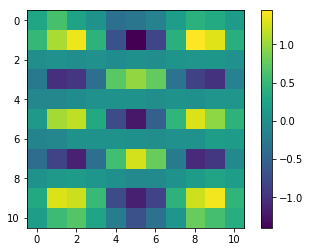

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

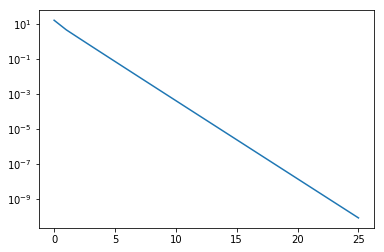

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.37563729134561175


In [16]:
wnew

array(0.83456131)

Rrestriction matrix after optimization

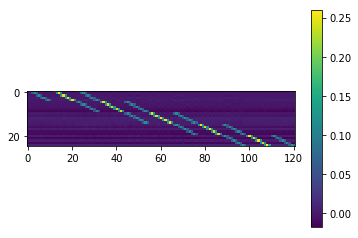

In [17]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

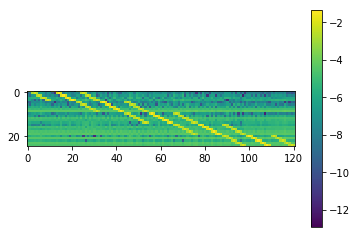

In [18]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

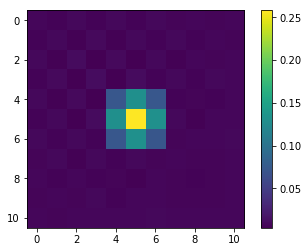

In [19]:
basis1 = Rnew[int(0.5*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

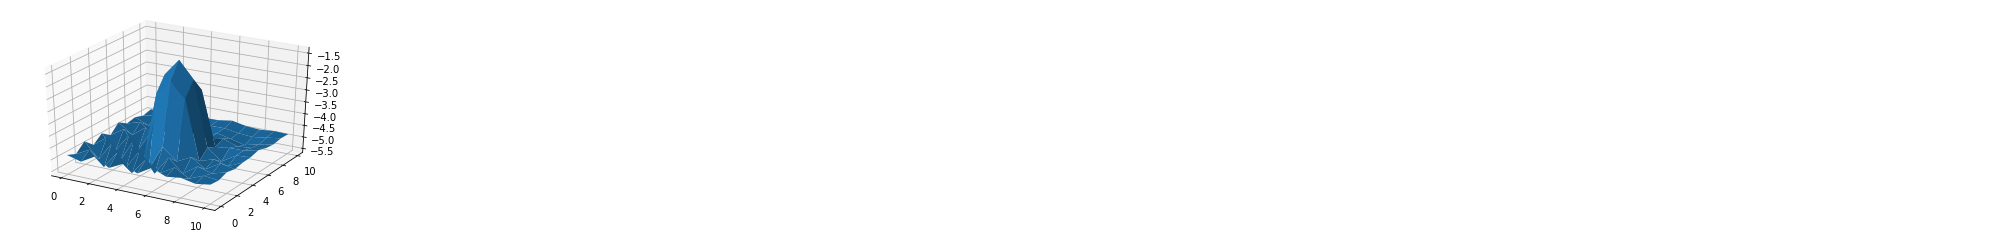

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(abs(basis1)))
plt.show()

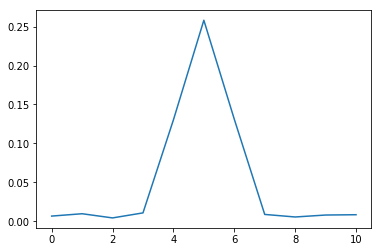

In [21]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

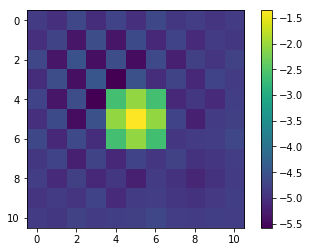

In [22]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

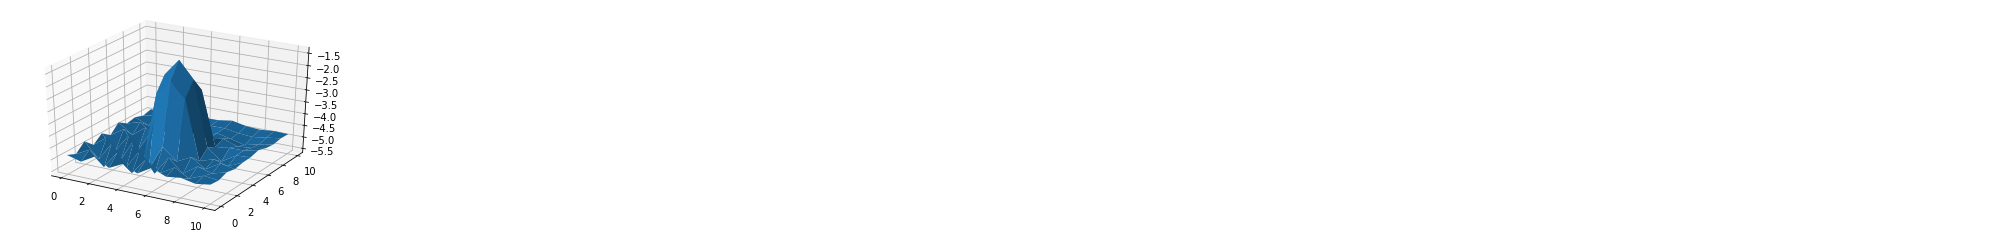

In [23]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

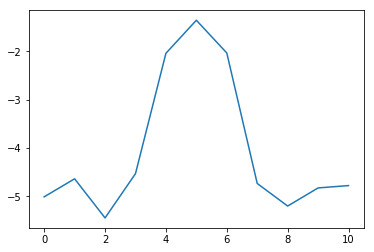

In [24]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
11.045530917495132
L2 norm: 
0.9708834074593538
H1 norm: 
7.980211163082323
Energy norm: 
1.1085090558490505
L2 norm: 
1.9417668149187075
H1 norm: 
1.1298695001268284


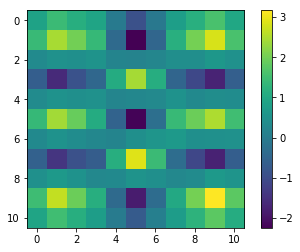

In [25]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [26]:
import os
os.system("say 'The program has finished, Please check the results'")

0